# Analyser

## Kode

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_target_histogram(df: pd.DataFrame, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    sns.countplot(df['Churned'], ax=ax)
    ax.set_xticklabels(['Kunde', 'Forladt'])
    ax.set_ylabel('Antal')
    ax.set_xlabel('')
    n_non_churned = len(df[df['Churned'] == 0])
    n_churned = len(df[df['Churned'] == 1])
    # ax.set_ylim([0, max(n_non_churned, n_churned) + 20])

    customer_counts = np.array(df.groupby('Churned')['UserId'].count())
    total_count = customer_counts.sum()
    customer_pct = (customer_counts / total_count) * 100

    for i in range(len(customer_pct)):
        p = ax.patches[i]
        percentage = '{:.2f}%'.format(customer_pct[i])
        x = p.get_x()
        y = np.nan_to_num(p.get_y() + p.get_height())
        ax.annotate(percentage, (x, y), fontsize=12)
    return ax
        
def get_annotation_data(df: pd.DataFrame, feature_name: str):
    customer_counts_per_products = list(df[df['Churned'] == 0].groupby(feature_name)['UserId'].count())
    if feature_name == 'NumOfProducts':
        customer_counts_per_products += [0]
    noncustomer_counts_per_products = list(df[df['Churned'] == 1].groupby(feature_name)['UserId'].count())
    customer_counts = np.array(customer_counts_per_products)
    noncustomer_counts = np.array(noncustomer_counts_per_products)
    total_counts = customer_counts + noncustomer_counts
    customer_pct = customer_counts / total_counts
    noncustomer_pct = noncustomer_counts / total_counts
    return np.append(customer_pct, noncustomer_pct)

def plot_histogram(df: pd.DataFrame, feature_name: str, ax=None, annotate: bool = True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(x=feature_name, hue='Churned', data=df, ax=ax)

    if annotate:
        annotation_data = get_annotation_data(df, feature_name)
        for i in range(len(annotation_data)):
            p = ax.patches[i]
            percentage = '{:.0f}%'.format(100 * annotation_data[i])
            x = p.get_x()
            y = np.nan_to_num(p.get_y() + p.get_height())
            ax.annotate(percentage, (x, y), fontsize=12)  

def plot_index_vs_value(df: pd.DataFrame, feature_name: str, target_name: str = None):
    """Visualisation for determining repeated values.
    Horisontal line segments indicate repeated values.
    Vertical line segments indicate data is not properly shuffled.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    if target_name is None:
        ax.plot(df[feature_name], '.')
    else:
        x = range(len(df[feature_name]))
        y = df[feature_name]
        ax.scatter(x=list(x), y=list(y), c=df[target_name], s=3, cmap='cool', alpha=0.5)
    ax.set_ylabel(feature_name)
    ax.set_xlabel('Index')
    
def plot_dual_histogram(df: pd.DataFrame, feature_name: str, bins=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
    df_unchurned = df[df['Churned'] == 0][feature_name]
    df_churned = df[df['Churned'] == 1][feature_name]
    ax.hist(df_unchurned, label='Kunde', alpha=0.5, bins=bins, color=plot_colors[0])
    ax.hist(df_churned, label='Forladt', alpha=0.5, bins=bins, color=plot_colors[1])
    ax.set_xlabel(feature_name)
    
def get_counts(df: pd.DataFrame, feature_name: str, style_format: str = '{:,.1f}'):
    df_counts = pd.DataFrame(df[feature_name].value_counts())
    # df_counts['Proportion'] = df_counts[feature_name].apply(lambda x: '{:.1f} %'.format(x / df_counts[feature_name].sum() * 100))
    df_counts['Proportion'] = df_counts[feature_name].apply(lambda x: x / df_counts[feature_name].sum() * 100)
    return df_counts.T.style.format(style_format)

def plot_corr(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(
        df.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        ax=ax
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );


In [3]:
plot_colors = sns.color_palette()

## Behov

- Det er dyrt at få kunder i butikken så det gælder om at holde fast i de kunder man har.
- Der er et ønske om at forudsige om en kunde er på vej væk så man kan gøre noget aktivt for at disse kunder
- Det er vigtigt at forstå om der er mønster i dataene så kan.
- Der er et ønske om at forudsige om en kunde er på vej til at ud af døren. 

## Indlæsning af data

Mål med at kigge på dataene er:
- Håndter manglende værdier
- Handter underlige værdier/outliers
- Hvordan hænger de forskellige features sammen?
- Er data balanceret?

Det lader til at de data som jeg har fået er fra Kaggle: https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

Filen er ikke så stor så vi kan sagtens hente al data ind i hukommelsen vha. Pandas.

- Overvej hvad vil man gøre når data er for stor.
   - Pandas kan sagtens håndtere data som fylder omkring 1GB
   - Hvis det fylder mere skal kigge på hukommelsesforbruget.
     - Man kan bruge `pd.read_csv(.., chunksize=100000)` - antallet af rækker der skal processeres ad gangen. Husk at man får ikke end DataFrame
     - Brug andre data typer for kolonnerne. Færre bits kræver mindre RAM.

In [4]:
df_data = pd.read_csv('data.csv', index_col=0) # Default Pandas starte sit index på 0

## Overblik

In [5]:
df_data.head()

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
Index,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df_data.shape

(10000, 13)

Hvor mange unikke kunder?

In [7]:
df_data['UserId'].nunique()

10000

## Data typer

In [8]:
df_data.dtypes

UserId              int64
LastName           object
CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance           float64
NumOfProducts       int64
HasCreditCard       int64
IsActiveMember      int64
Salary            float64
Churned             int64
dtype: object

In [9]:
id_features = set(['UserId', 'LastName'])
categorical_features = set(['Geography', 'Gender'])
boolean_features = set(['HasCreditCard', 'IsActiveMember'])
continuous_features = set(['CreditScore', 'Age', 'Tenure', 'Balance', 'Salary', 'NumOfProducts'])

## Manglede værdier

Manglende værdier er tit et problem når man sidder med data i den virkelig verden.

In [10]:
df_missing = pd.DataFrame(df_data.isnull().sum(), columns=['No. of missing values']).T

In [11]:
df_missing

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
No. of missing values,0,0,0,0,0,0,0,0,0,0,0,0,0


Umiddelbare tanker:
- Havde forventet at der var nogle manglede værdier. Data virker renset.

Ved manglende værdier har man flg. muligheder:

- Slette dem med `df_data.dropna(axis=0, thresh=5)`. Vær forsigtig. Kig evt. på andelen af manglende værdier.
- Udfylde dem med f.eks.
  - Gennemsnitsværdi `df_data['Salary'].fillna(value=df_data['Salary'].mean())`. Godt til kontinuerlig data uden outliers.
  - Medianen: Godt kontinuerlig data med outliers.
  - Mode: Flest forekommmende værdi. Godt for kategorisk kolonne.



Igen man skal være forsigtigt med at udfylde data med statistikker fordi disse påvirker korrelationen mellem to variabler.

> Please note that Mean, Median and Mode imputation diminishes any correlations involving the variable(s) that are imputed. This is because we assume that there is no relationship between the imputed variable and any other measured variables. Thus, those imputations have some attractive properties for univariate analysis but become problematic for multivariate analysis. [https://medium.com/@george.drakos62/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca]

> Although imputing missing values by using the mean is a popular imputation technique, there are serious problems with mean imputation. The variance of a mean-imputed variable is always biased downward from the variance of the un-imputed variable. This bias affects standard errors, confidence intervals, and other inferential statistics. Experts agree that mean imputation should be avoided when possible (Allison (2009), Horton and Kleinman (2007)). [https://blogs.sas.com/content/iml/2017/12/06/problems-mean-imputation.html]

## Kontinuerte features

Mål:
- Undersøg om der er underlige værdier i de enkelte feature.
- Få en fornemmelse af om værdierne giver mening.
- Undersøg mulighederne for at oprette nye features udfra indsights

### Kredit score

In [12]:
df_data[['CreditScore']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
CreditScore,"10,000",651,97,350,584,652,718,850


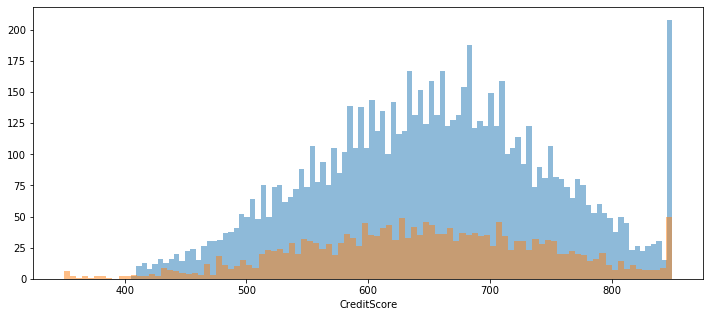

In [13]:
plot_dual_histogram(df_data, 'CreditScore', bins=100)

- Værdierne ligger i intervallet 350 til 850. 
- Mangler information omkring denne feature. Antager datasættet er fra et europæisk bank fordi `Geography` $\in$ \[ France, Spain, Germany \]. 
- Generelt: datasættet indeholder større observationer af personer som forbliver kunder fremfor personer, der forlader banken. Vær opmærksom på ubalanceret data.
- Passer nogenlunde med [amerikansk FICO](https://en.wikipedia.org/wiki/Credit_score) hvor scoren er fra 300 til 850. 
- Umiddelbart ser fordelingerne nogenlunde ens ud.
- Der er et peak ved 850. Lader til at der er en stor andel som har den højest kreditscore. 

Hypotese: fordeling for kunder med CreditScore 850 er anderledes end dem under 850.

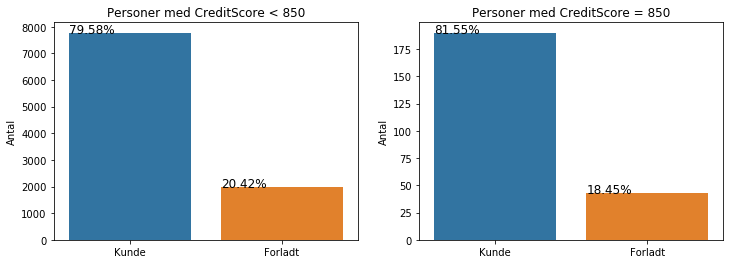

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_target_histogram(df_data[df_data['CreditScore'] < 850], ax[0])
plot_target_histogram(df_data[df_data['CreditScore'] == 850], ax[1])
ax[0].set_title('Personer med CreditScore < 850');
ax[1].set_title('Personer med CreditScore = 850');

Det lader ikke til at der er den forskel i fordelingerne.

Man kunne overveje at lave en ny kategorisk feature.

### Alder

In [15]:
df_data[['Age']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Age,"10,000",39,10,18,32,37,44,92


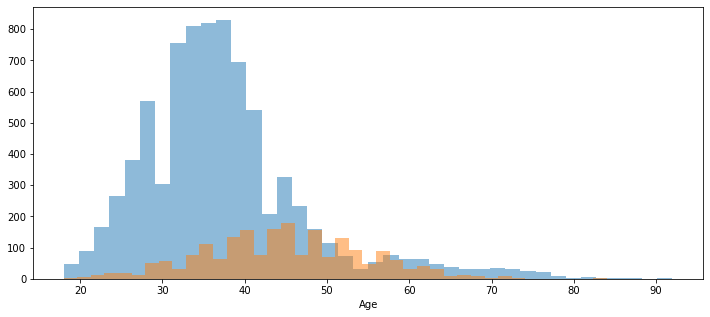

In [16]:
plot_dual_histogram(df_data, 'Age', bins=40)

- Alder fra 18 til 92. Ikke noget mærkeligt.
- Det lader til at der er forskel i aldersfordeling mellem kunder og ikke-kunder. 
- Kan muligvis udnyttes til at inddele kunder i forskellige aldersgruppe så en model har nemmere ved at adskille yngre og ændre kunder fra hinanden.

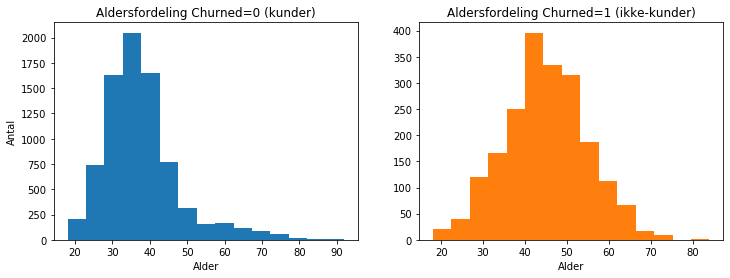

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df_data[df_data['Churned'] == 0]['Age'], bins=15, color=plot_colors[0]);
ax[1].hist(df_data[df_data['Churned'] == 1]['Age'], bins=15, color=plot_colors[1]);
for i in range(2):
    ax[i].set_xlabel('Alder')
ax[0].set_title('Aldersfordeling Churned=0 (kunder)')
ax[1].set_title('Aldersfordeling Churned=1 (ikke-kunder)')
ax[0].set_ylabel('Antal');

In [18]:
# df_data['AgeGroup'] = pd.cut(df_data['Age'], bins=15, right=False).astype(str)
df_data['AgeGroup'] = pd.cut(df_data['Age'], bins=15, right=False).apply(lambda x: int(x.left))
categorical_features.add('AgeGroup')

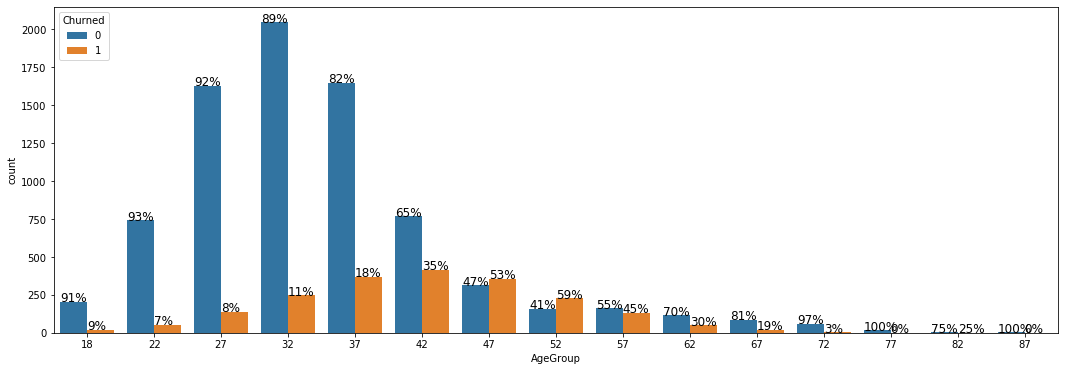

In [19]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_histogram(df_data.sort_values('AgeGroup'), 'AgeGroup', annotate=True, ax=ax)

In [20]:
df_age_groups_dummies = pd.get_dummies(df_data['AgeGroup'], prefix='IsInAgeGroup', prefix_sep='')
df_data = df_data.merge(df_age_groups_dummies, left_index=True, right_index=True)

### Tenure

In [21]:
df_data[['Tenure']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Tenure,"10,000",5,3,0,3,5,7,10


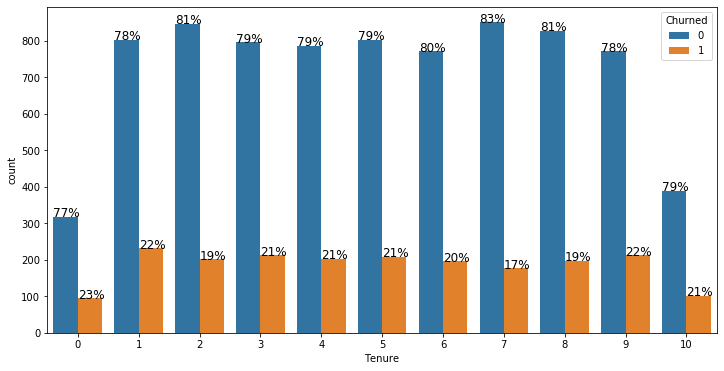

In [22]:
plot_histogram(df_data, 'Tenure', annotate=True)

- Integer værdier fra 0 til 10. Ukendt om det er måneder eller år.
- Fordelinger er nogenlunde ens.
- Overvej om denne feature skal laves om til en kategoriske feature.

In [23]:
continuous_features.remove('Tenure')
categorical_features.add('Tenure')

In [24]:
df_tenure_dummies = pd.get_dummies(df_data['Tenure'], prefix='IsInTenure', prefix_sep='')
df_data = df_data.merge(df_tenure_dummies, left_index=True, right_index=True)

### Balance

In [25]:
df_data[['Balance']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Balance,"10,000","76,486","62,397",0,0,"97,199","127,644","250,898"


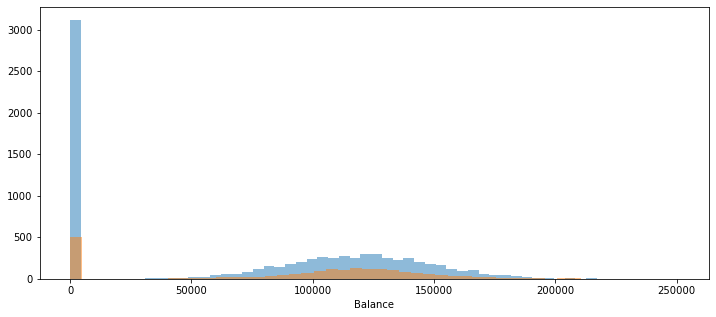

In [26]:
plot_dual_histogram(df_data, 'Balance', bins=50)

- Antager det er valuta er i euro. Max værdien €250.898 virker meget højt, men det er vel ikke unormalt.
- Lidt underligt at kunder som har forladt banken har noget indestående. Antager at det er det beløb som tidligere kunder havde stående før de forlod banken
- Andelen af kunder med formuer som forlader banken er større end dem med 0 i indstående.
- Ide til ny feature: boolean feature om man har penge stående i banken.

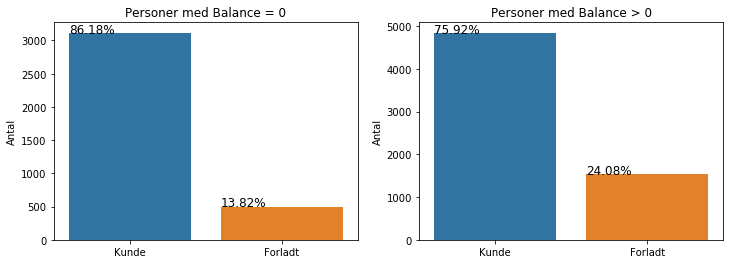

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
threshold_value = 0
plot_target_histogram(df_data[df_data['Balance'] == threshold_value], ax[0])
plot_target_histogram(df_data[df_data['Balance'] > threshold_value], ax[1])
ax[0].set_title('Personer med Balance = {}'.format(threshold_value));
ax[1].set_title('Personer med Balance > {}'.format(threshold_value));

In [28]:
df_data['HasAnyDeposit'] = df_data['Balance'].apply(lambda x: int(x > 0))
categorical_features.add('HasAnyDeposit')

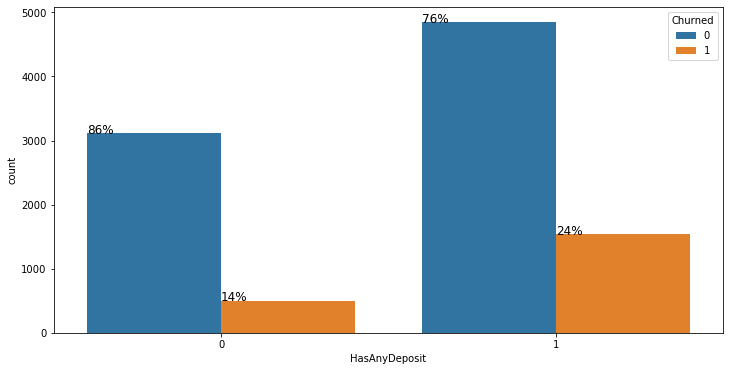

In [29]:
plot_histogram(df_data, 'HasAnyDeposit', annotate=True)

### Løn

In [30]:
df_data[['Salary']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
Salary,"10,000","100,090","57,510",12,"51,002","100,194","149,388","199,992"


Værdierne virker pæne ud! Lad os kigge på fordelingen.

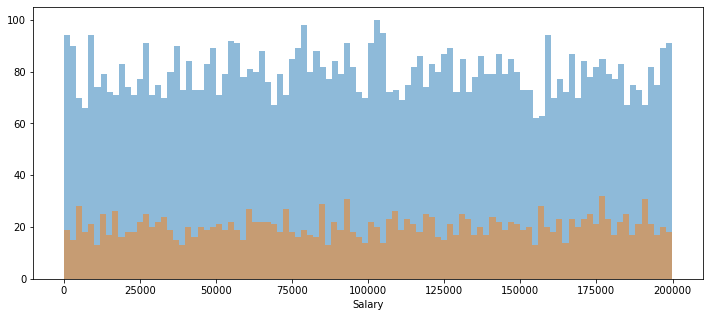

In [31]:
plot_dual_histogram(df_data, 'Salary', bins=100)

Denne feature har en uniform fordeling. Får et indtryk af at værdierne er genereret tilfældigt.

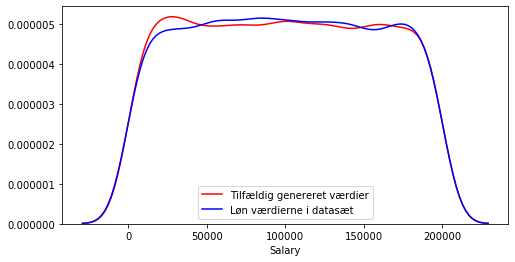

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
random_salary = np.random.uniform(low=0, high=200000, size=10000)
sns.distplot(random_salary, hist=False, label='Tilfældig genereret værdier', color='red', ax=ax)
sns.distplot(df_data['Salary'], hist=False, label='Løn værdierne i datasæt', color='blue', ax=ax);

Noget tyder på at **Salary** er syntetisk. Måske er data genereret på baggrund af reelle data for at anonymsere det.

### Antal bankydelser (NumOfProducts)

In [33]:
df_data[['NumOfProducts']].describe().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,"10,000",2,1,1,1,1,2,4


- Antager at dette er antallet af bankydelser som kunden har haft på det tidspunkt data er blevet udtrukket.
- 75% af kunderne har 2 eller 1 bankydelse tilknytter


Lad os kigge på fordelingen.

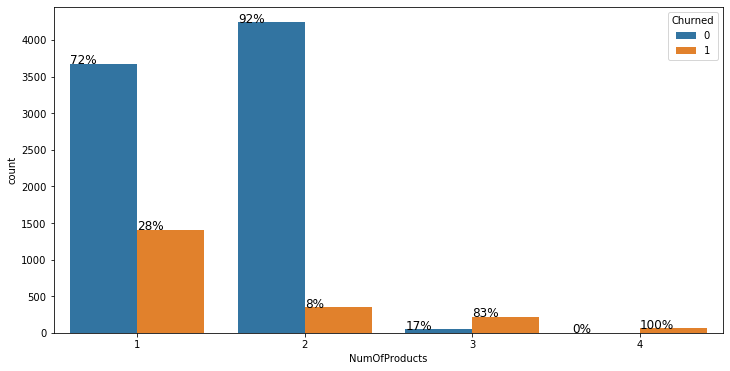

In [34]:
plot_histogram(df_data, 'NumOfProducts')

Observationer:
- Ingen af de nuværende kunder har 4 produkter!
- Hvis en kunde har 3 bankydelser så er der høj chance for at den kunde forlader butikken.
- Høj signal i denne feature. Betragt den som en kategorisk feature.

In [35]:
continuous_features.remove('NumOfProducts')
categorical_features.add('NumOfProducts')

## Kategoriske felter

### Lokation (Geography)

In [36]:
get_counts(df_data, 'Geography')

,France,Germany,Spain
Geography,"5,014.0","2,509.0","2,477.0"
Proportion,50.1,25.1,24.8


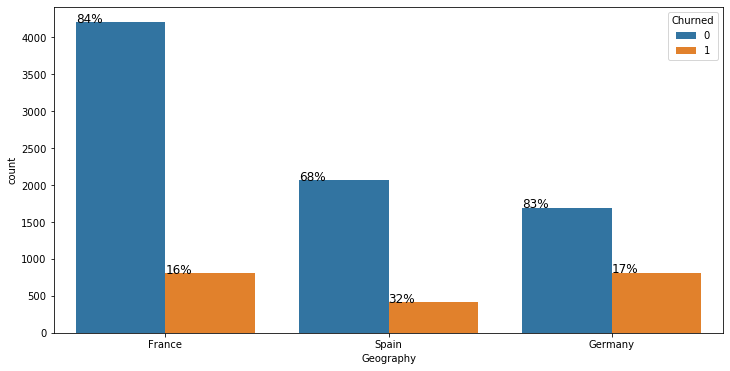

In [37]:
plot_histogram(df_data, 'Geography', annotate=True)

- Halvdelen af personer er fra Frankrig. Ca 25% fra Tyskland og resterende fra Spanien.
- Andelen af kunder og ikke-kunder er nogenlunde det samme i Frankrig og Tyskland
- I Spanien er der en relativ høj andel af ikke-kunder ifht. kunder.

In [38]:
df_geo_dummies = pd.get_dummies(df_data['Geography'], prefix='IsFrom', prefix_sep='')
df_data = df_data.merge(df_geo_dummies, left_index=True, right_index=True)

### Køn (Gender)

In [39]:
get_counts(df_data, 'Gender')

,Male,Female
Gender,"5,457.0","4,543.0"
Proportion,54.6,45.4


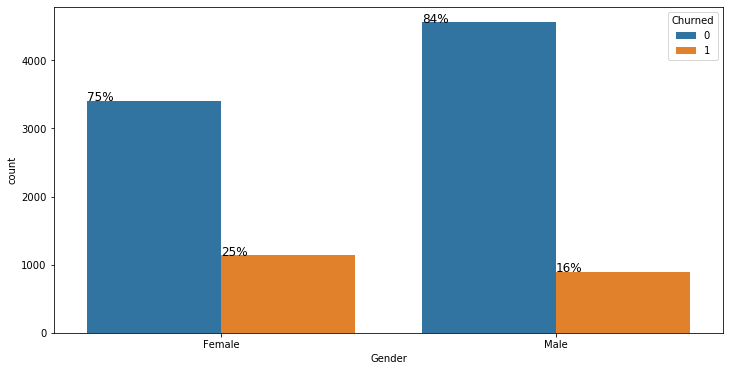

In [40]:
plot_histogram(df_data, 'Gender', annotate=True)

- Ca. 55% mænd og 45% kvinder
- En lidt højere andel af kvindelige kunder forlader banken.

In [41]:
df_data['IsMale'] = df_data['Gender'].apply(lambda x: int(x == 'Male'))

### Har kredit kort (HasCreditCard)

In [42]:
get_counts(df_data, 'HasCreditCard')

,1,0
HasCreditCard,"7,055.0","2,945.0"
Proportion,70.5,29.4


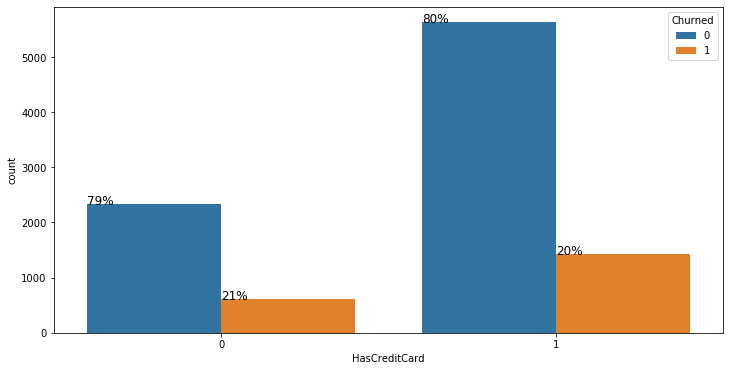

In [43]:
plot_histogram(df_data, 'HasCreditCard', annotate=True)

- Ca. 71% af personerne har (haft) kreditkort
- Nogenlunde samme fordeling i de to klasser

### Er aktiv (IsActiveMember)

In [44]:
get_counts(df_data, 'IsActiveMember')

,1,0
IsActiveMember,"5,151.0","4,849.0"
Proportion,51.5,48.5


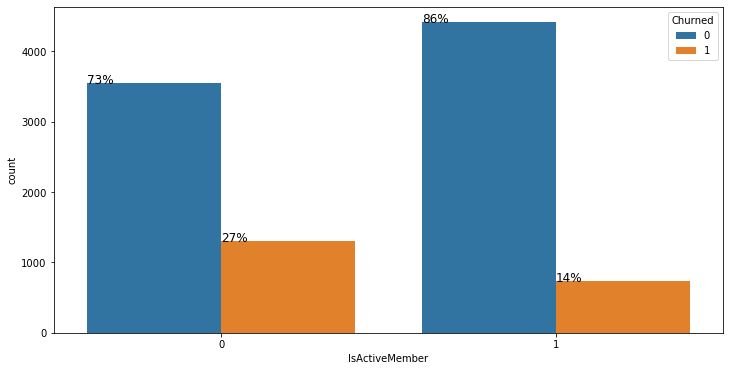

In [45]:
plot_histogram(df_data, 'IsActiveMember', annotate=True)

- Ca. 52% af personerne er aktive (hvad end det betyder)
- Højere andel af ikke-aktive kunder forlader banken

### Target feature (Churned)

Vi har tidligere set at datasættet er ubalaceret. Lad os kigge på hvor stor er ubalancen.

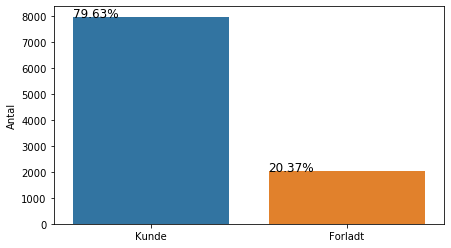

In [46]:
plot_target_histogram(df_data);

Fordelingen er 1:4. Vi kan ikke bruge accuracy. Vi skal bruge F1 score og ROC area under curve.

Der er to udfordringer som vi skal løst:
1. ubalanceret data øger risikoen for at vores model performer dårlig fordi den bliver biased mod den store klasse dvs. minoritetsklassen bliver modeleret mindre godt
2. omkostningen ved at prædiktere forkert på kunder der er ved at forlade banken er højere end en forkert prediktion i den omvendte situation
   - hvis modellen prædikterer at en kunde vil blive mens kunden er på vej ud så er det en større fejl end hvis modellen prædiktere at en kunde er på vej ud men i virkligheden vil kunden slet ikke nogen steder
   - derfor skal modellen ikke lave type fejl

Det er nok mere interessant at studere kunder, der er på vej væk.


## Relationer mellem features

Lad os kigge på om vi kan få flere insights ved at kigge på features parvis. Histogrammer viser ikke interaktioner mellem forskellige features.

In [47]:
# Backup up ID features and remove them from the working dataframe
df_data_ids = df_data[id_features].copy()
df_data.drop(id_features, axis=1, inplace=True)

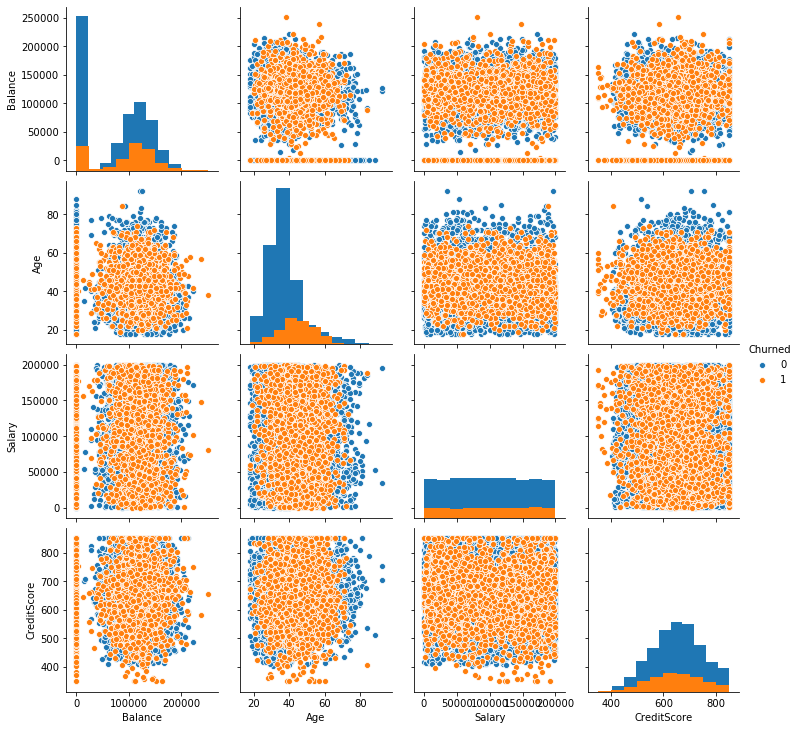

In [48]:
sns.pairplot(df_data, vars=continuous_features, hue='Churned', diag_kind='hist')

Umiddelbart ikke klare korrelationer mellem disse features.


Lad os kigge på korrelationer mellem alle features.

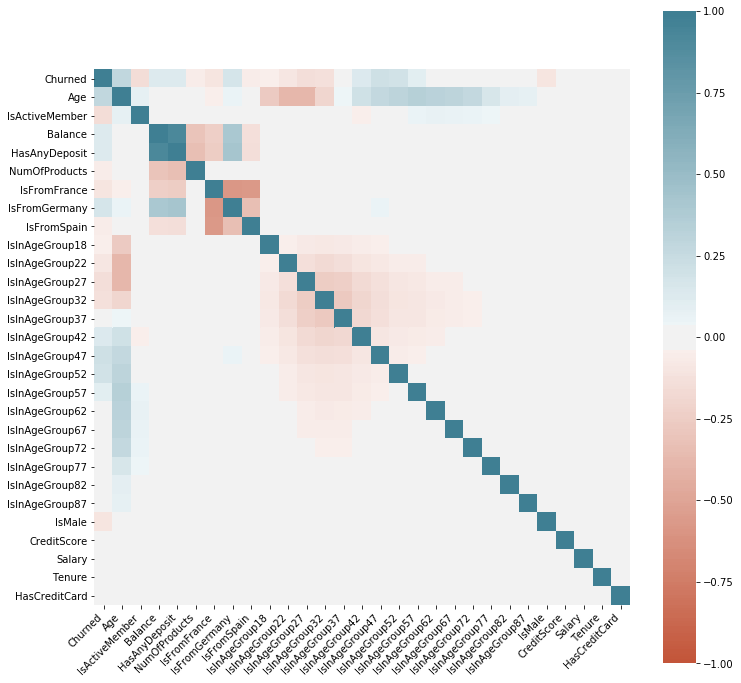

In [49]:
columns = [
    'Churned', 'Age', 'IsActiveMember', 'Balance', 'HasAnyDeposit', 'NumOfProducts', 
    'IsFromFrance', 'IsFromGermany', 'IsFromSpain',
    'AgeGroup', 'IsInAgeGroup18', 'IsInAgeGroup22', 'IsInAgeGroup27', 'IsInAgeGroup32',
    'IsInAgeGroup37', 'IsInAgeGroup42', 'IsInAgeGroup47', 'IsInAgeGroup52', 'IsInAgeGroup57',
    'IsInAgeGroup62', 'IsInAgeGroup67', 'IsInAgeGroup72', 'IsInAgeGroup77', 'IsInAgeGroup82', 'IsInAgeGroup87',
    'IsMale', 'CreditScore', 'Salary', 'Tenure', 'HasCreditCard'
]
plot_corr(df_data[columns])

- Høj korrelation mellem `HasAnyDeposit` og `Balance`! Overvej at fjerne `HasAnyDeposit` da det ikke tilføjer mere information.
- CreditScore, Salary, Tenure og HasCreditCard har ingen correlation med nogen af de andre features
- Umiddelbart ikke noget som springer i øjnene.

Lad os prøve at finde gruppe af features vha. clustering.

In [50]:
sns.diverging_palette(20, 220, n=200, as_cmap=True)

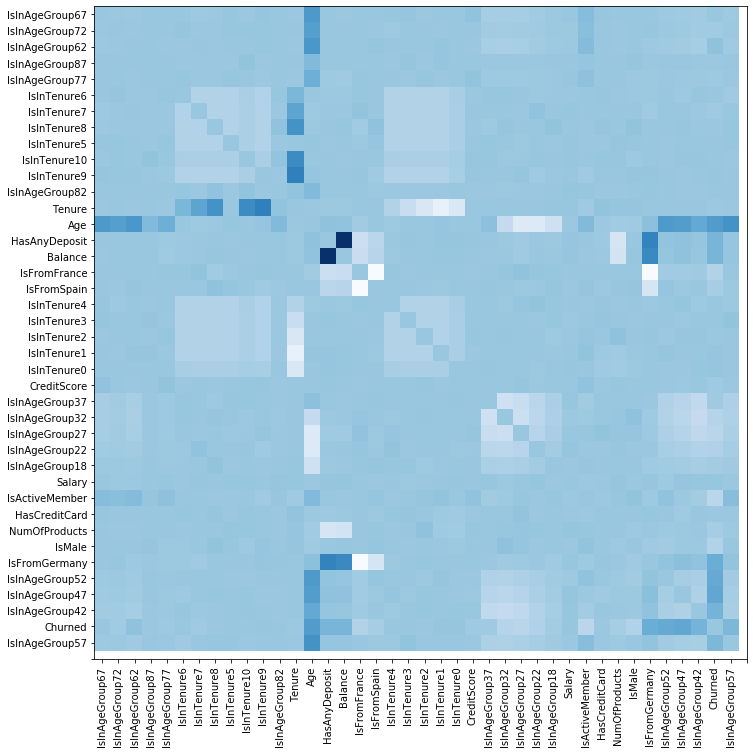

In [51]:
from sklearn.cluster import SpectralBiclustering
corr_columns = list(df_data.corr().columns)
df_corr_data = np.array(df_data.corr())

# Slet variancen for at skabe bedre clusters
I = np.eye(*df_corr_data.shape)
df_corr_data = df_corr_data - I  

# Forsøg at skabe nogle clusters
model = SpectralBiclustering(n_clusters=7, method='log', random_state=42)
model = model.fit(df_corr_data)

# Sorter rækker og kolonner
fit_data = df_corr_data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

# Plot data
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(fit_data, cmap=plt.cm.Blues)

# Får tekster på plot
reordered_cols_idx = np.argsort(model.column_labels_)
reordered_columns = [corr_columns[i] for i in reordered_cols_idx]
ax.set_xticklabels(reordered_columns,  rotation=90);
ax.set_yticklabels(reordered_columns);
ax.set_xticks(list(range(41)))
ax.set_yticks(list(range(41)))
ax.xaxis.set_ticks_position('bottom');

## Klargøring af data

Mange ML modeller kræver at features er normaliseret eller skaleret. Der er forskellige feature skaleringer:
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): er godt hvis man ens feature er normalt fordelt
- 
- [RobustScaler](https://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers): når data indeholder mange outliers

### Hvorfor skifter man bank?

Mybankers [bankundersøgelse](https://www.mybanker.dk/artikler/hver-fjerde-dansker-har-skiftet-bank-de-seneste-5-aar/) i 2018 viser flg.:

| Årsager til ikke at skifte bank (flere svar) | %   |
|----------------------------------------------|-----|
| Tror ikke bedre vilkår er muligt             | 70% |
| Det kræver meget tid og energi               | 34% |
| Ny netbank, dankort, kode og kontonumre      | 33% |
| Ny rådgiver                                  | 17% |
| Mange omkostninger                           | 12% |
| At det er for kompliceret                    | 11% |
| Går bag om ryggen på nuværende bank          | 2%  |

| Årsag til overvejet bankskifte  | %   |
|---------------------------------|-----|
| Priser / Gebyrer / Renter       | 65% |
| Rådgivning - Kvalitet           | 29% |
| Værdier                         | 19% |
| Lokale filialer                 | 14% |
| Kemi med personalet             | 11% |
| Service                         | 10% |
| Teknologi - netbank / mobilbank | 7%  |

3052 besvarelser indsamlet feb 2018 til apr 2018 (3 mdr). Indsamlet Mybankers sociale mediekanaler og abonnenter af Mybankers nyhedsbrev. Kun 19 banker indgår i analysen.

## Andre data som kunne være relevant?

- Dataene er en snapshot. Hvad betyder det?
- Balance:
  - Transaktioner, hvornår man har sat penge ind på kontoen kunne være relevant. 
  - Snapshot viser ikke om man har trukket alle sine penge ud.
- Balance og hvor aktiv man er:
  - Kunne være interessant at kigge på det.
- Transkationer så i stedet for `IsActiveMember` så kan man måske grader hvor aktiv kunden er. Det kunne give mere information
- Istedet for `NumOfProducts` hvilke produkter har kunderne købt  kunne give mere information 
- Kunder som ikke exited men som stadig har noget stående på deres konti.
- Mangler noget kontekst for dataene. Hvordan dataene er trukket ud og konteks omkring data kunne gøre man har en bedre forståelse for hvordan man skal lave modeller.
